In [1]:
# suppress warnings
import warnings
warnings.simplefilter('ignore')
# import installed packages
import pandas as pd
import numpy as np
import xarray as xr
from statsmodels.tsa.seasonal import STL
# import functions from custom modules
import sys
sys.path.insert(0,'/Users/Kathy/Desktop/UW/seaflow/decomposition_project/scripts/')
from diel_tools import *
from fig_tools import *
from tsd_functions import *
from rate_functions import *
from simulation_tools import *

# Generate simulated 10 day dataset from Zinser et al experimental data
1. Combine Hourly Qc data, PAR, gross 14C fixation, carbon loss into one dataset. 
>a) Calculate net carbon fixation from gross fixation and carbon loss
2. Repeat days from original dataset 5x to get 10 day simulated dataset.
3. Randomly remove data of certain percentages.
4. Run iterative interpolation to impute new values. 
5. Compare imputed values against original values to calculate error (RMSE).
6. Block bootstrap to get uncertainites for productivity measurements.

### Calculating hourly Qc from FCM and combining with measurements data
Returns single dataframe with all necessary data for analysis: `pro_data`

In [2]:
# read in flow cytometry data
culture_data=pd.read_csv('simulation_data/zinser_figure2a.csv')
psd_data=pd.read_csv('simulation_data/zinser_psd.csv')

#### reformat to calculate hourly average Qc ####
# get experimental time from culture dataset
X = list(culture_data['exper time'])
# get size classes from psd data columns
Y = list(psd_data.columns[1:].astype(float))
# get particle size distrubition data from dataframe
Z = psd_data.iloc[:,1:].T.to_numpy()

# make new dataframe with particle size distribution data and reset the index
df = pd.DataFrame(data=Z, columns=X, index=Y).reset_index()
# rename column to size_bin
df.rename(columns={'index':'size_bin'},inplace=True)
# reformat data from wide to long
df_long=pd.melt(df, id_vars=['size_bin'], var_name='hour', value_name='abundance')
# calculate sum of each size bin using size and abundance
df_long['Qc_sum'] = df_long['size_bin'] * df_long['abundance']
# filter out size classes with no abundance
df_long = df_long[df_long.abundance > 0]

# group by cruise and date to get n and summed qc by the hour
df_group = df_long.groupby(['hour']).sum().reset_index()
# get mean Qc per hour and convert Qc from fg -> pg
df_group['Qc_hour'] = (df_group['Qc_sum']/df_group['abundance'])/1000
# subset just the columns we care about
pro_data = df_group[['hour','Qc_hour']]

#### Add in PAR and measurements data ####
# get PAR data
ds = xr.open_dataset('simulation_data/zinser_processed.nc',
                    decode_times=False)
pro_data['par']=ds.PAR.values
# get c-fixation and loss data
gt = xr.open_dataset('simulation_data/zinser_ground_truth.nc',
                    decode_times=False)
# get carbon fixation for all rows in pg
pro_data['GPP']=gt.carbonfix.values/1000
# get carbon loss for all rows except last in pg
pro_data.loc[0:23,'carbonloss']=gt.carbonloss.values/1000
# add net c-fiszation for all rows
pro_data['NPP'] = pro_data['GPP']-pro_data['carbonloss']

ValueError: found the following matches with the input file in xarray's IO backends: ['netcdf4', 'h5netcdf']. But their dependencies may not be installed, see:
https://docs.xarray.dev/en/stable/user-guide/io.html 
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html

### Generate 10 day simulated dataset
Cuts off the last day to repeat to produce continuous transition into next simulated days

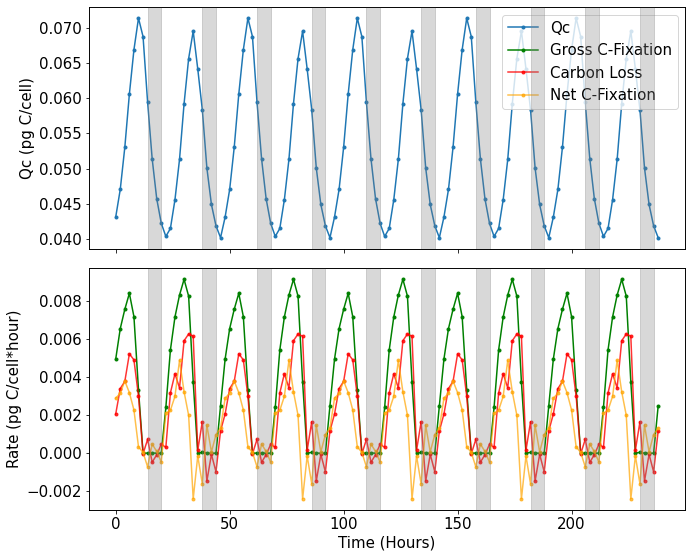

In [6]:
# create 10 day simulated data for Qc data
ten_days=generate_simulated(pro_data, 10)

#### Plot to check if simulation successful ####
plot_simulated_rates(ten_days)

### Randomly remove data 
Try with varying percentages of missing data

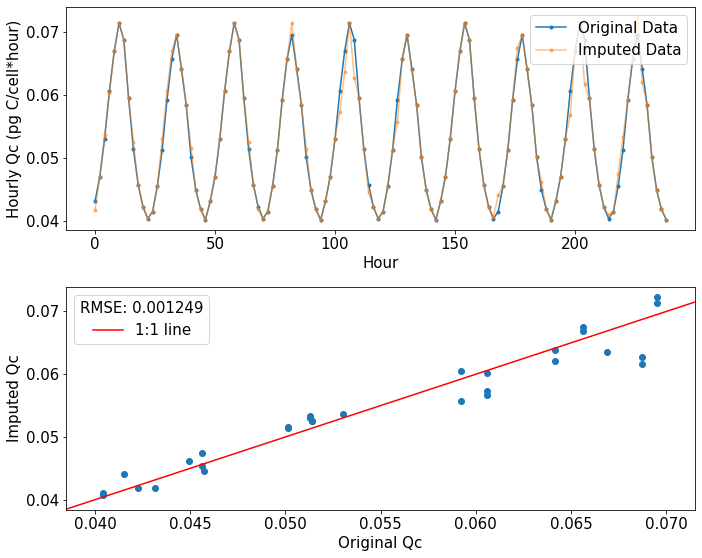

In [7]:
from sklearn.metrics import mean_squared_error
# generate missing data
missing_25=generate_missing_data(ten_days, 0.25)
# calculate imputed values
impute_df=run_imputation(missing_25)

#### plot results ####
plot_imputed(impute_df)

### Calculate growth rates and productivity on imputed datasets
Compare against measurements to get error

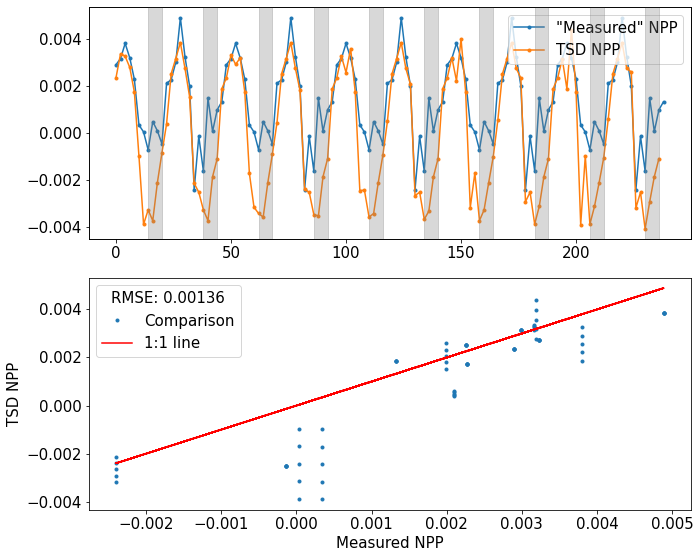

In [12]:
# suppress warnings
import warnings
warnings.simplefilter('ignore')

# get tsd components
tsd_df=run_STL(impute_df, 'with_missing')
# calculate hourly growth by exponential growth and maintain correct order
tsd_df['hourly_growth']=exp_growth(tsd_df, 'diel',2).shift(-1)
# calculate hourly productivity
rates_df=calc_productivity(tsd_df,'hourly_growth','Qc_hour')

#### Plot results ####
plot_productivity(tsd_df)

### Run moving block bootstrapping (MBB) on models to get uncertainty values

1. Get residual values
2. Separate residuals into _l_ length blocks
3. Randomly draw with resampling to create new time series of residuals
4. Combine with seasonal and trend components to generate new synthetic time series
5. Calculate new productivity values from synthetic time series
6. Repeat **_n_** times to get distribution of error

#### References
- Medium [guide](https://medium.com/@daydreamersjp/bootstrapping-on-time-series-data-moving-block-bootstrap-79aaf6648aec)
- Bergmeier et al. [slides](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://cbergmeir.com/talks/bergmeir2014ISF_slides.pdf)
- Medium [tutorial (with paywall)](https://archive.ph/LSshc)


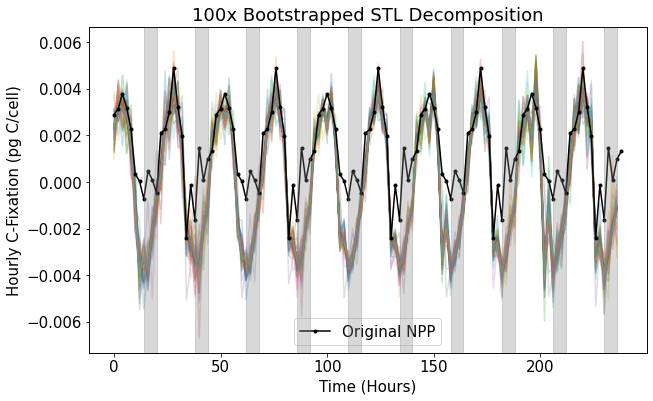

In [13]:
# run bootstrapping to get list of new dataframes
runs=100
mbb_df, mbb_data=run_bootstrapping(tsd_df, runs=runs)
plot_bootstrapping(mbb_df, mbb_data, runs)

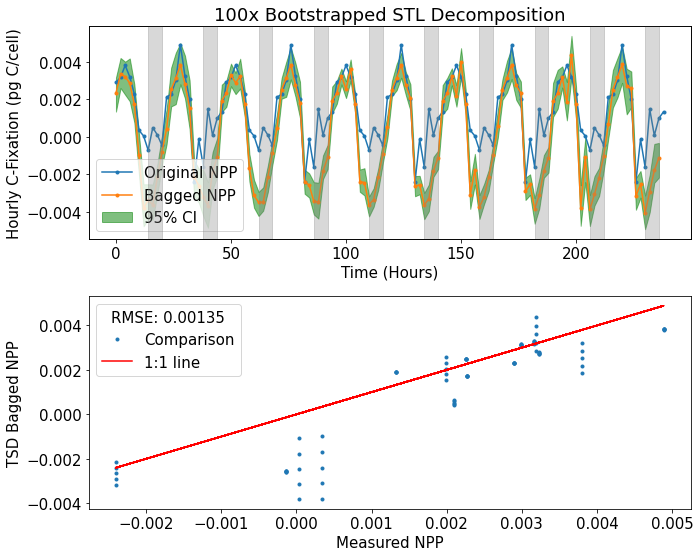

In [14]:
# perform bagging on bootstrapped data
bagged=bagging_results(mbb_data)

## plot results
fig,rmse=plot_bagging(bagged)

### Put it all together and test for amount of data removed
Uncomment cell below to rerun, but this takes about ~15 minutes to complete. Alternatively, run the preloaded pickle file to check previous results 

- This cell runs bagged model 100x to collect aggregated error (RMSE) in this case. 

In [24]:
# # list of data percentages to remove
# to_remove=[0, 0.1, 0.25, 0.4, 0.5, 0.6]
# # save error metrics distribution
# rmse_dist=[]
# # run model 100 times to collect error distributions
# for i in range(0,100):
#     # save rmses in each proportion
#     print(i)
#     rmses=[]
#     # run model for several iterations
#     for prop in to_remove:
#         # run model
#         fig, rmse=run_full_model(pro_data, 10, prop,100, show_plots=False)
#         plt.close()
#         print(f'data removed: {prop} and error: {rmse}')
#         # save rmse
#         rmses.append(rmse)
#     # save list of rmses
#     rmse_dist.append(rmses)

## Save file
# rmse_df=pd.DataFrame(rmse_dist)
# rmse_df.columns = to_remove
# rmse_df.to_pickle('simulation_data/rmse_df')

In [25]:
# read pickled data
rmse_df=pd.read_pickle('simulation_data/rmse_df')

### Post-hoc procedure for ranking models
- What type of error do I want to minimize and why?

For example, I could use the Hochberg post-hoc method to reduce the number of false positives. This would mean that I would prioritize against incorrectly rejecting the true null hypothesis. I could use the true results (NPP values) as a control and the different models to compare against. The baseline would be Annette's method to calculate NPP. 

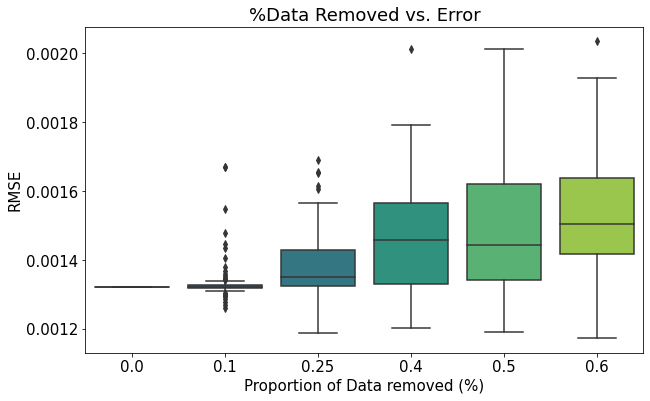

In [20]:
import seaborn as sns

error_long=rmse_df.melt(var_name='removed', value_name='rmse')
fig,axs=plt.subplots(figsize=(10,6))
sns.boxplot(data=error_long, x='removed',y='rmse', palette=sns.color_palette("viridis"))
axs.set_xlabel('Proportion of Data removed (%)')
axs.set_ylabel('RMSE')
axs.set_title('%Data Removed vs. Error')
plt.show()

### CONSTRUCTION ZONE BEYOND THIS CELL###
![construction sign](https://media.istockphoto.com/id/1423867660/vector/traffic-road-barrier-road-closed-warning-barrier-flat-vector-illustrations-for-website-under.jpg?s=1024x1024&w=is&k=20&c=xXqtDUeaaaFlqN4cFyvv6rBLyzpuZF89cEKbus2Rw-M=)

### Perform time series train-test split and blocked cross validation (jk i don't think this works)
- Split time series data into training and testing
- Perform k-fold cross validation on varying blocks

**References**
- TS CV [blog post](https://goldinlocks.github.io/Time-Series-Cross-Validation/)
- Netpune AI [tutorial](https://neptune.ai/blog/select-model-for-time-series-prediction-task)
- Medium [blog post ](https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4)

In [ ]:
# helper function to 
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=None)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)
        
#     # Plot the data classes and groups at the end
#     ax.scatter(range(len(X)), [ii + 1.5] * len(X),
#                c=y, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) #+ ['class']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+1.2, -.1], xlim=[0, 100])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

In [45]:
# code from reference listed above
## class to define blocked split for training and testing data for time series CV
class BlockingTimeSeriesSplit():
    # initialize object
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    # class function to return # splits
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    # function to create blocked splits by works by adding margins at two positions. The first is between the 
    # training and validation folds in order to prevent the model from observing lag values which are used twice, 
    # once as an estimator (regressor) and another as a response. The second is between the folds used at 
    # each iteration in order to prevent the model from memorizing patterns from one iteration to the next.
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        # get size of each split
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)
        # split evenly between training and testing
        margin = 0
        # get indices of data for each split 
        for i in range(self.n_splits):
            # set beginning and end of split
            start = i * k_fold_size
            stop = start + k_fold_size
            # get middle of split to start testing
            mid = int(0.5 * (stop - start)) + start
            # pause function to return splits for training and testing
            yield indices[start: mid], indices[mid + margin: stop]

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# visualize split for normal time series split and blocking
cvs = [TimeSeriesSplit, BlockingTimeSeriesSplit]

for cv in cvs:
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 5))
    plot_cv_indices(this_cv, X, y, ax, n_splits)

    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
            ['Testing set', 'Training set'], loc=(1.02, .8))
    plt.tight_layout()
    fig.subplots_adjust(right=.7)
        
plt.show()

In [37]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
# create time series split object
tscv = TimeSeriesSplit(n_splits = 4)
# set error metrics
rmse = []
# run grab training indices from truth data
NPP_truth=tsd_df.NPP.values
# for train_index, test_index in tscv.split(cross_validation):
#     cv_train, cv_test = cross_validation.iloc[train_index], cross_validation.iloc[test_index]
    
#     arma = sm.tsa.ARMA(cv_train, (2,2)).fit(disp=False)
    
#     predictions = arma.predict(cv_test.index.values[0], cv_test.index.values[-1])
#     true_values = cv_test.values
#     rmse.append(sqrt(mean_squared_error(true_values, predictions)))
    
# print("RMSE: {}".format(np.mean(rmse)))

In [43]:
counter=0
for train_index, test_index in tscv.split(NPP_truth):
    print(counter)
    print(f'train: {train_index}')
    print(f'test: {test_index}')
    counter+=1

0
train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
test: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
1
train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
test: [48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
2
train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
test: [72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
3
train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 